In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('./Food/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./Food/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./Food/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i].parent.name)  # Use the parent directory as the label
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)


# Display the unique labels in sorted order
unique_labels = sorted(train_df.Label.unique())

print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(unique_labels)}\n')
print(f'Labels: {unique_labels}')

-- Training set --

Number of pictures: 1847

Number of different labels: 20

Labels: ['Alpukat', 'Apel', 'Ayam', 'Bayam', 'Brokoli', 'Bubur', 'Ikan Salmon', 'Jagung', 'Kentang', 'Kiwi', 'Labu', 'Lobak', 'Melon', 'Nasi', 'Pepaya', 'Pisang', 'Roti', 'Susu', 'Tahu', 'Telur']


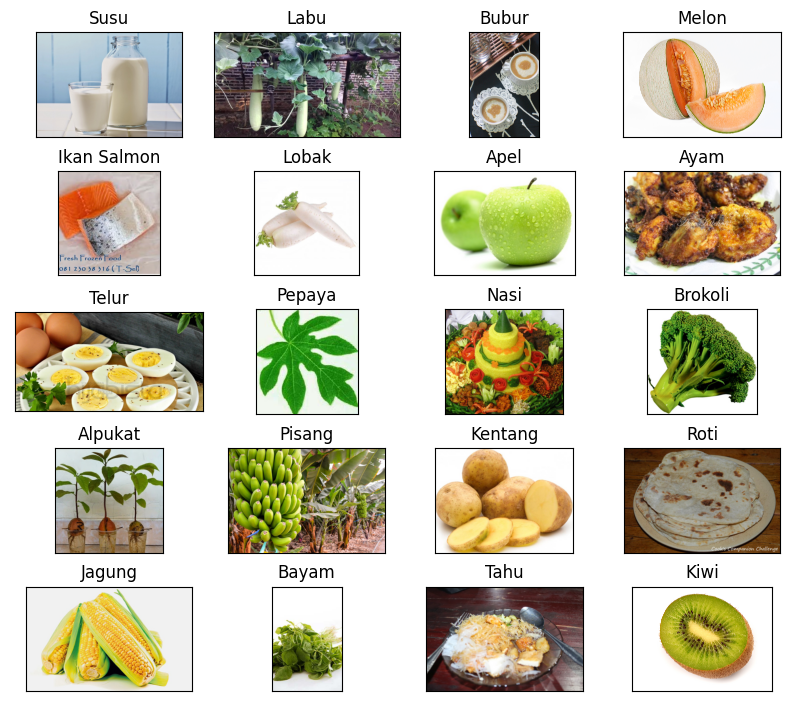

In [3]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
num_images_to_display = min(36, len(df_unique))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(num_images_to_display):
    ax = axes.flat[i]
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [4]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1847 validated image filenames belonging to 20 classes.
Found 922 validated image filenames belonging to 20 classes.
Found 922 validated image filenames belonging to 20 classes.


In [5]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [7]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
58/58 [==============================] - 73s 1s/step - loss: 1.6865 - accuracy: 0.5463 - val_loss: 0.8253 - val_accuracy: 0.7495
Epoch 2/5
58/58 [==============================] - 34s 587ms/step - loss: 0.6609 - accuracy: 0.8100 - val_loss: 0.5493 - val_accuracy: 0.8492
Epoch 3/5
58/58 [==============================] - 34s 583ms/step - loss: 0.3665 - accuracy: 0.8988 - val_loss: 0.3810 - val_accuracy: 0.9100
Epoch 4/5
58/58 [==============================] - 33s 577ms/step - loss: 0.2033 - accuracy: 0.9540 - val_loss: 0.4130 - val_accuracy: 0.8937
Epoch 5/5
58/58 [==============================] - 34s 582ms/step - loss: 0.1127 - accuracy: 0.9800 - val_loss: 0.2858 - val_accuracy: 0.9306


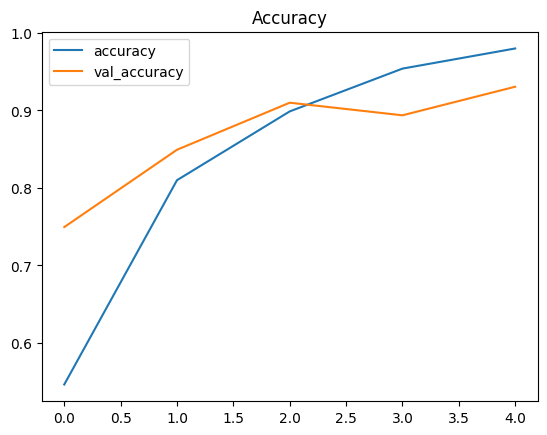

In [8]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

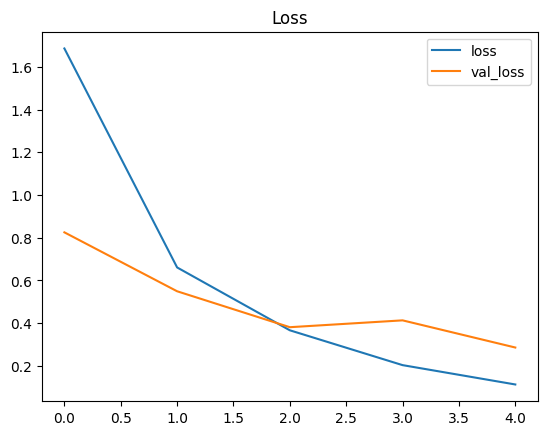

In [9]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [10]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

29/29 [==============================] - 13s 400ms/step


In [11]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 93.06%


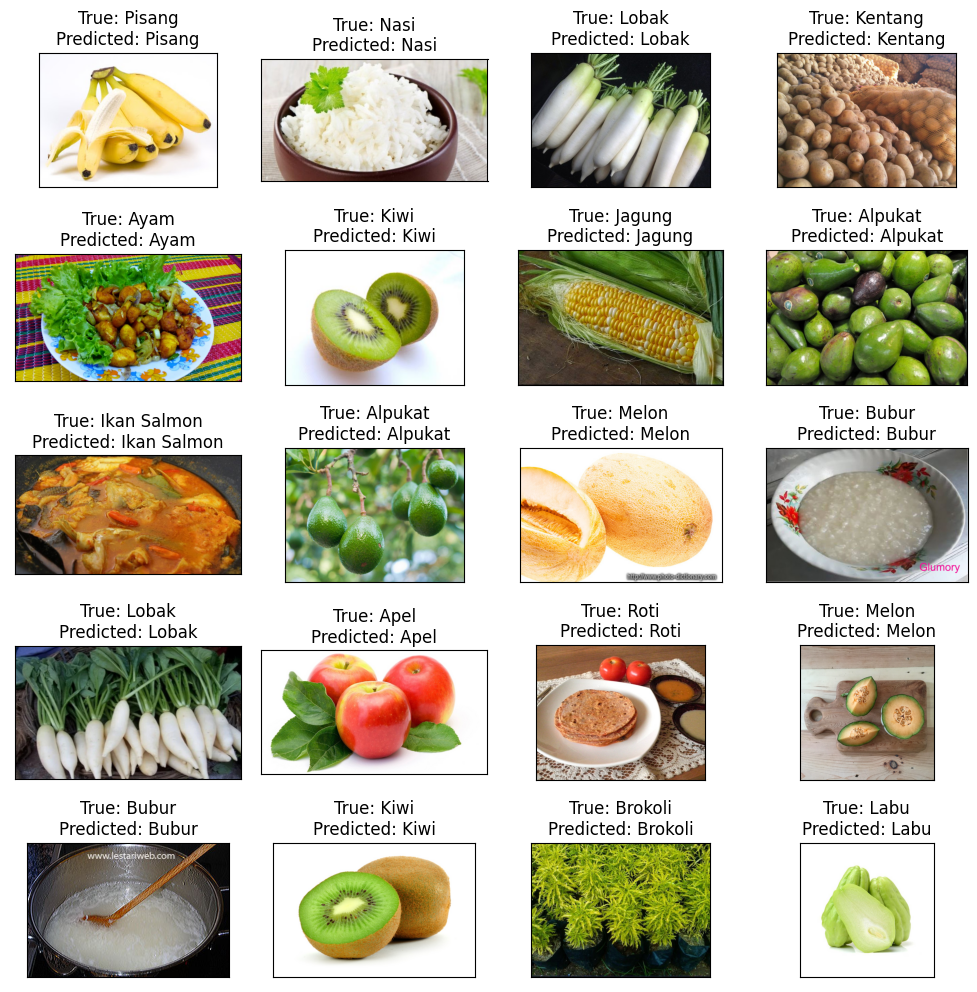

In [12]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [13]:
model.save('./food_classification_93.h5')